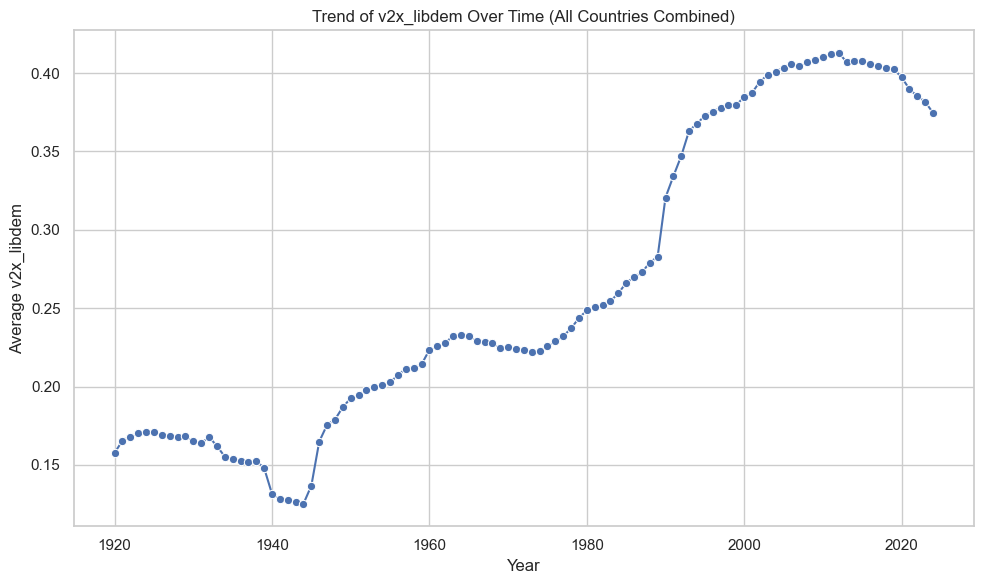

In [12]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

# Set the plot style to mimic ggplot2
plt.style.use('ggplot')
sns.set_theme(style='whitegrid')

# Load the V-Dem dataset (adjust the file path as necessary)
# The CSV is assumed to have at least 'year' and 'v2x_libdem' columns.
df = pl.read_parquet('../vdemData/V-Dem-CY-Full+Others-v15.parquet')
df = df.filter(pl.col("year") >= 1920)

# Group by year and calculate the mean of v2x_libdem across all countries
df_yearly = df.group_by("year").agg(pl.col("v2x_libdem").mean().alias("avg_v2x_libdem"))
df_yearly = df_yearly.sort("year")  # Ensure the data is sorted by year

# Convert the Polars DataFrame to Pandas for easier plotting with seaborn
pdf = df_yearly.to_pandas()

# Plot the average v2x_libdem over time
plt.figure(figsize=(10, 6))
sns.lineplot(x="year", y="avg_v2x_libdem", data=pdf, marker="o")
plt.xlabel("Year")
plt.ylabel("Average v2x_libdem")
plt.title("Trend of v2x_libdem Over Time (All Countries Combined)")
plt.tight_layout()
plt.savefig("../writeup/plots/v2x_libdem_avg_all_countries.png", dpi=300)
plt.show()


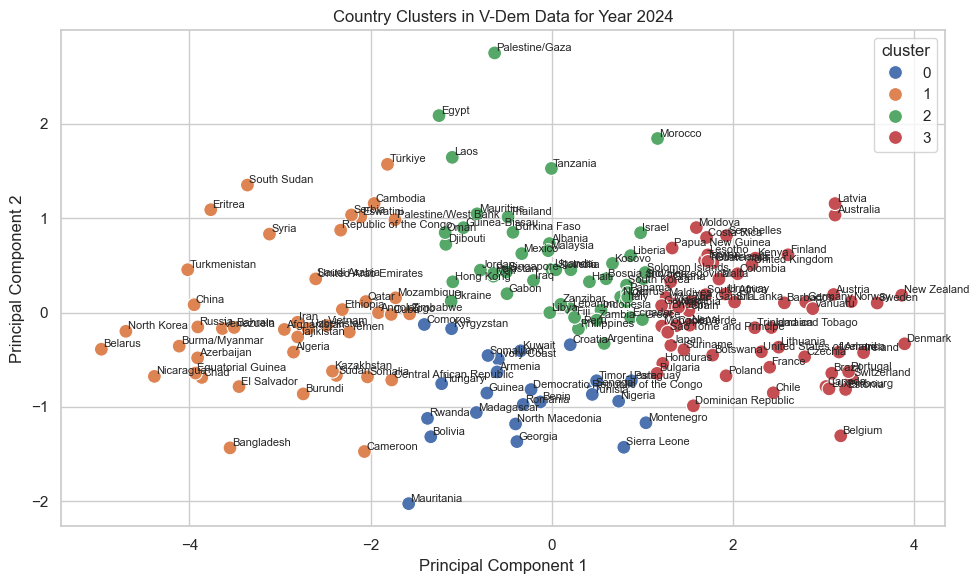

In [8]:
import polars as pl
import pandas as pd
from functools import reduce
import operator
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style to mimic ggplot2
plt.style.use('ggplot')
sns.set_theme(style='whitegrid')

# -------------------------------
# 1. Load & Prepare the Data
# -------------------------------

# Load the V-Dem dataset; adjust file path as needed


# For clustering analysis, use a snapshot from the latest available year
latest_year = df['year'].max()
df_latest = df.filter(pl.col('year') == latest_year)

# Define features to capture democracy indicators
features = [
    'v2x_libdem',   # Liberal Democracy Index
    'v2juhcind',    # Judicial independence
    'v2mecenefm',   # Media freedom
    'v2xcs_ccsi',   # Civil society robustness
    'v2xeg_eqdr'    # Economic equality measures
]

# Combine the null check conditions for all features into a single predicate
null_condition = reduce(operator.and_, [pl.col(col).is_not_null() for col in features])
df_latest = df_latest.filter(null_condition)

# Convert to Pandas DataFrame for use with sklearn and seaborn
pdf = df_latest.to_pandas()

# -------------------------------
# 2. Dimensionality Reduction & Clustering
# -------------------------------

# Extract features and the corresponding country names
X = pdf[features]
countries = pdf['country_name']

# Reduce dimensions to 2 using PCA for plotting
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Apply KMeans clustering (example: 4 clusters)
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Add PCA results and cluster labels to the DataFrame
pdf['PCA1'] = X_pca[:, 0]
pdf['PCA2'] = X_pca[:, 1]
pdf['cluster'] = clusters

# -------------------------------
# 3. Plotting the Clusters
# -------------------------------

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pdf, x='PCA1', y='PCA2', hue='cluster', palette='deep', s=100, legend='full')

# Optionally, annotate points with country names
for _, row in pdf.iterrows():
    plt.text(row['PCA1'] + 0.02, row['PCA2'] + 0.02, row['country_name'], fontsize=8)

plt.title(f'Country Clusters in V-Dem Data for Year {latest_year}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()
plt.show()
